## Inference in non-Gaussian stochastic volatility models

This tutorial demonstrates inference using the Levy [Stable](http://docs.pyro.ai/en/stable/distributions.html#stable) distribution.

In [1]:
import math
import os
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints
from pyro import poutine
from pyro.infer import EnergyDistance, SVI, Trace_ELBO
from pyro.infer.autoguide import (AutoDelta, AutoDiagonalNormal, AutoLowRankMultivariateNormal,
                                  init_to_median)
from pyro.infer.reparam import SymmetricStableReparam
from pyro.optim import ClippedAdam


%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']

In [2]:
df = pd.read_csv(os.path.expanduser("~/Downloads/snp500.csv"))
#df = pd.read_csv(os.path.expanduser("~/Downloads/KO.csv"))

In [3]:
x = torch.tensor(df["Close"]).float()
# torch.save(x, os.path.expanduser("~/Downloads/snp500_daily_open.pkl"))

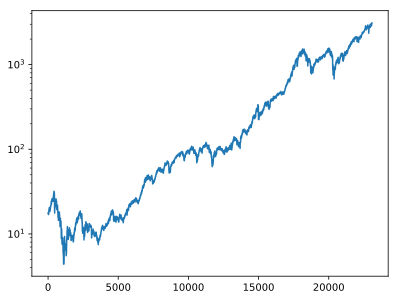

In [4]:
pyplot.plot(x)
pyplot.yscale('log')

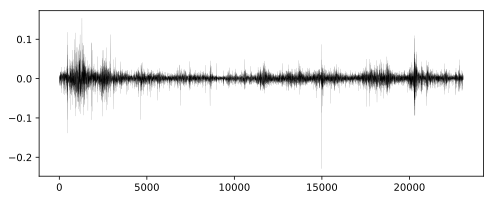

In [5]:
pyplot.figure(figsize=(8, 3), dpi=300)
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1);

mean = 0.00022394036932382733
std = 0.011869287118315697


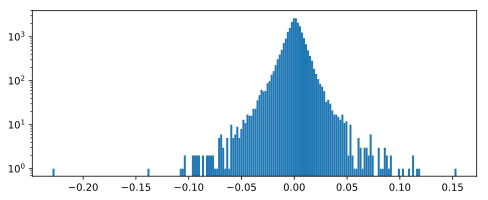

In [6]:
pyplot.figure(figsize=(8, 3))
pyplot.hist(r, bins=200)
pyplot.yscale('log')
print("mean = {}".format(r.mean()))
print("std = {}".format(r.std()))

First let's fit a single distribution to the returns.

In [7]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 8.09205436706543
step 20 loss = 2.358262538909912
step 40 loss = 1.483095645904541
step 60 loss = 1.3339297771453857
step 80 loss = 1.3538814783096313
step 100 loss = 1.30342698097229
step 120 loss = 1.290689468383789
step 140 loss = 1.2755258083343506
step 160 loss = 1.2772961854934692
step 180 loss = 1.2793216705322266
step 200 loss = 1.2758824825286865
loc = 0.000173179927514866
scale = 0.008449478074908257
stability = 1.9810322523117065
CPU times: user 1min 41s, sys: 8.32 s, total: 1min 49s
Wall time: 17.1 s


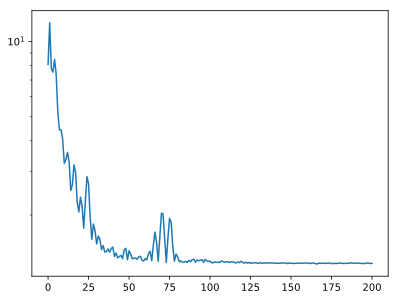

In [8]:
%%time
pyro.clear_param_store()
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
num_steps = 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance(num_particles=10))
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

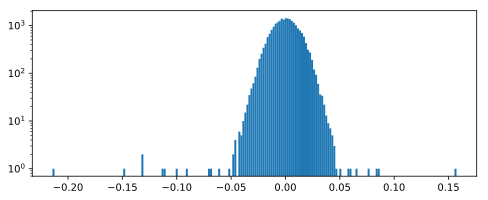

In [9]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(8, 3), dpi=300)
pyplot.hist(samples, bins=200)
pyplot.yscale('log')

This is a poor fit, but that's to be expected since we're mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, StudentT, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling in Pyro

Consider a stochastic volatity model of the log returns `r_t` and a latent volatility `h`:
$$
  \log h_t = \delta + \phi \log h_{t-1} + \sigma v_t \\
  r_t = w_t \sqrt{h_t}
$$
Usually $\sigma v_1$ and $w_t$ are both Gaussian. We will generalize to Student t and Stable distributions.

In [10]:
def model(data):
    time_plate = pyro.plate("time", len(data))

    # We model volatility is a Stable OU process.
    # This is expressed as a factor graph.
    h_timescale = pyro.sample("h_timescale", dist.LogNormal(math.log(1000), 0.01))
    h_decay = (-1 / h_timescale).exp()
    h_stability = pyro.sample("h_stability", dist.Uniform(1.5, 2.0))
    h_skew = 0.
    h_scale = pyro.sample("h_scale", dist.LogNormal(-10, 3))
    h_loc = pyro.sample("h_loc", dist.Normal(0, 3))
    with time_plate:
        log_h = pyro.sample("log_h", dist.Normal(0, 0.01).mask(False))
    with pyro.plate("dtime", len(data) - 1):
        pyro.sample("h_noise", dist.Stable(h_stability, h_skew, h_scale, h_loc),
                    obs=log_h[..., 1:] - log_h[..., :-1] * h_decay)

    # Observed log returns.
    r_stability = pyro.sample("r_stability", dist.Uniform(1.5, 2.0))
    r_skew = 0.
    r_scale = log_h.mul(0.5).exp()
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2))
    with time_plate:
        r = pyro.sample("r", dist.Stable(r_stability, r_skew, r_scale, r_loc),
                        obs=data)

    return log_h.detach(), r.detach()

step 0 loss = 8.81395e+11, timescale = 957
step 50 loss = 6.29465e+07, timescale = 90.9
step 100 loss = 339030, timescale = 63.7
step 150 loss = 255553, timescale = 401
step 200 loss = 224550, timescale = 1.06e+03
step 250 loss = 199418, timescale = 976
step 300 loss = 174347, timescale = 943
step 350 loss = 151935, timescale = 960
step 400 loss = 131145, timescale = 1.01e+03
step 450 loss = 113707, timescale = 986
step 500 loss = 97877.2, timescale = 993
step 550 loss = 85914.4, timescale = 1.02e+03
step 600 loss = 76683.7, timescale = 1e+03
step 650 loss = 70976.1, timescale = 1.01e+03
step 700 loss = 65604.1, timescale = 1.01e+03
step 750 loss = 62183.4, timescale = 993
step 800 loss = 58816, timescale = 998
step 850 loss = 56793.4, timescale = 1e+03
step 900 loss = 54804.5, timescale = 1e+03
step 950 loss = 54925.2, timescale = 991
h_loc = -0.0017571360804140568
h_scale = 0.049661923199892044
h_stability = 1.9929769039154053
h_timescale = 1007.5784301757812
r_loc = -0.0015922128222

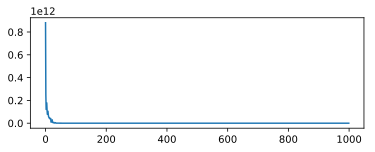

In [11]:
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
num_steps = 1000
optim = ClippedAdam({"lr": 0.05, "lrd": 0.1 ** (1 / num_steps)})
reparam_model = poutine.reparam(model, {"h_noise": SymmetricStableReparam(),
                                        "r": SymmetricStableReparam()})
guide = AutoDiagonalNormal(reparam_model)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}, timescale = {:0.3g}".format(
            step, loss, median["h_timescale"].item()))

pyplot.figure(figsize=(6,2))
pyplot.plot(losses)
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

Text(0, 0.5, 'volatility')

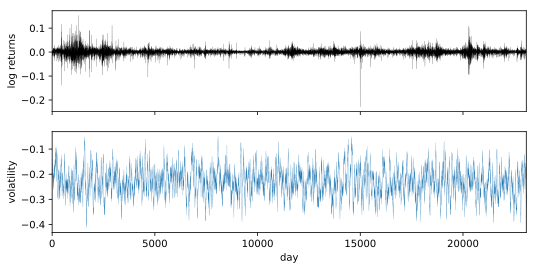

In [12]:
fig, axes = pyplot.subplots(2, figsize=(8.5, 4), sharex=True)
axes[0].plot(r, "k", lw=0.2)
axes[0].set_ylabel("log returns")
axes[0].set_xlim(0, len(r))
log_h = guide.median()["log_h"].detach()
axes[1].plot(log_h, lw=0.2)
axes[1].set_xlabel("day")
axes[1].set_ylabel("volatility")